In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
import numpy as np
import os
import shutil

In [3]:
!rm -rf /kaggle/working/*

In [4]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.10, test_ratio = 0.10):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('CervicalCancerSplitDataset/train/' + cls)
        os.makedirs('CervicalCancerSplitDataset/valid/' + cls)
        os.makedirs('CervicalCancerSplitDataset/test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/valid/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "/kaggle/input/cervical-cancer-formatted-dataset/content/CervicalCancerFormattedDataset"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  650
Validation:  81
Testing:  82

Koilocytotic :
Total images:  825
Training:  660
Validation:  82
Testing:  83

Metaplastic :
Total images:  793
Training:  634
Validation:  79
Testing:  80

Parabasal :
Total images:  787
Training:  629
Validation:  79
Testing:  79

Superficial-Intermediate :
Total images:  831
Training:  664
Validation:  83
Testing:  84



In [5]:
import torch
from torchvision import datasets, transforms

data_dir = '/kaggle/working/CervicalCancerSplitDataset'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(28),
                                      transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(28),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=5)
valloader = torch.utils.data.DataLoader(valid_data, batch_size=5)

In [6]:
total_train_size = len(train_data)
total_test_size = len(test_data)
total_dev_size = len(valid_data)

classes = 5
input_dim = 784

num_clients = 5
rounds = 250
batch_size = 5
epochs_per_client = 15
learning_rate = .001

In [7]:
total_train_size, total_dev_size, total_test_size

(3237, 404, 408)

In [8]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [9]:
import torch.nn.functional as F
import torch.nn as nn


class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)
        self.fc2 = torch.nn.Linear(128, 5)
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'fc1': self.fc1, 'fc2': self.fc2}

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [10]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [11]:
from torch.utils.data import Subset, DataLoader

# Assuming `train_data` is your original dataset and `classes` is the total number of classes
num_clients = 3

# List to keep track of clients
clients = []

s_class=[]
e_class=[]
# Create non-IID imbalanced distribution
for i in range(num_clients):
    # Calculate the classes each client should have
    start_class = i * classes // num_clients
    end_class = (i + 1) * classes // num_clients
    s_class.append(start_class)
    e_class.append(end_class-1)

    # Create a list of indices corresponding to the desired classes
    class_indices = [idx for idx, label in enumerate(train_data.targets) if start_class <= label < end_class]

    # Use those indices to create a Subset of the original dataset for each client
    client_dataset = Subset(train_data, class_indices)

    # Create a Client object and add it to the list of clients
    client = Client('client_' + str(i), client_dataset)
    clients.append(client)

# Print information about each client
idx=1;
for client in clients:
    print(f"{client} has {len(client.dataset)} examples from classes {s_class[idx-1]} to {e_class[idx-1]}")
    idx+=1;

<__main__.Client object at 0x7fdd0e7e2350> has 650 examples from classes 0 to 0
<__main__.Client object at 0x7fdd0e7e0580> has 1294 examples from classes 1 to 2
<__main__.Client object at 0x7fdd0e7e1e40> has 1293 examples from classes 3 to 4


In [12]:
global_net = to_device(FederatedNet(), device)
history = []
history2 = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_data, batch_size)
    dev_loss, dev_acc = global_net.evaluate(valid_data, batch_size)
    print('After round {}, train_loss = {}, dev_loss = {}, train_acc = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), round(dev_loss, 4), round(train_acc, 4), round(dev_acc, 4)))
    history.append((train_acc, dev_acc))
    history2.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.0015, Accuracy = 1.0
client_1: Loss = 0.2999, Accuracy = 0.8662
client_2: Loss = 0.5027, Accuracy = 0.749
After round 1, train_loss = 1.468, dev_loss = 1.4713, train_acc = 0.4528, dev_acc = 0.4457

Start Round 2 ...
client_0: Loss = 0.0013, Accuracy = 1.0
client_1: Loss = 0.2866, Accuracy = 0.8784
client_2: Loss = 0.4471, Accuracy = 0.79
After round 2, train_loss = 1.3795, dev_loss = 1.389, train_acc = 0.4974, dev_acc = 0.4877

Start Round 3 ...
client_0: Loss = 0.001, Accuracy = 1.0
client_1: Loss = 0.2712, Accuracy = 0.8876
client_2: Loss = 0.3514, Accuracy = 0.8618
After round 3, train_loss = 1.3143, dev_loss = 1.3153, train_acc = 0.4903, dev_acc = 0.4914

Start Round 4 ...
client_0: Loss = 0.0007, Accuracy = 1.0
client_1: Loss = 0.2522, Accuracy = 0.8909
client_2: Loss = 0.2894, Accuracy = 0.8775
After round 4, train_loss = 1.2612, dev_loss = 1.2495, train_acc = 0.4958, dev_acc = 0.5037

Start Round 5 ...
client_0: Loss = 0.0007, Accuracy = 1.0


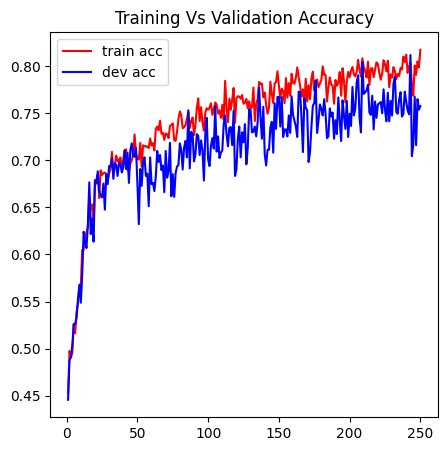

In [13]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train acc')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev acc')
plt.legend()
plt.title('Training Vs Validation Accuracy')
plt.show()

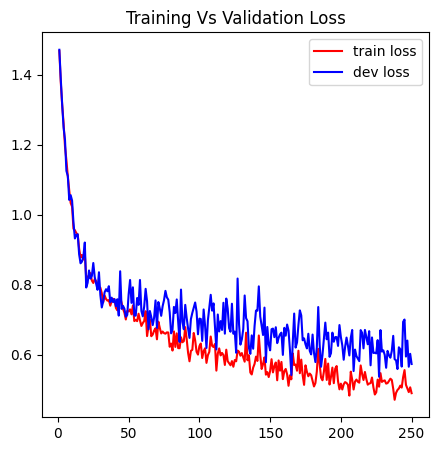

In [14]:
plt.plot([i + 1 for i in range(len(history2))], [history2[i][0] for i in range(len(history2))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history2))], [history2[i][1] for i in range(len(history2))], color='b', label='dev loss')
plt.legend()
plt.title('Training Vs Validation Loss')
plt.show()

In [15]:
# evaluate accuracy after training
global_net.eval()

FederatedNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [16]:
len(test_data)

408

In [17]:
checkpoint = {'model': FederatedNet(),
          'state_dict': global_net.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [18]:
# Make predictions on the test set
all_predictions = []
true_labels = []
with torch.no_grad():
    for test_data, test_labels in testloader:
        outputs = global_net(test_data)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.numpy())
        true_labels.extend(test_labels.numpy())

# 'all_predictions' now contains the predicted class labels, and 'true_labels' contains the true class labels
print("Predictions:", all_predictions)
print("True Labels:", true_labels)

Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 4, 1, 0, 1, 0, 2, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 4, 3, 1, 1, 1, 1, 0, 0, 0, 1, 4, 1, 1, 0, 4, 4, 4, 2, 4, 4, 1, 4, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2, 2, 3, 3, 2, 4, 4, 2, 0, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 2, 4,

In [19]:
# import seaborn as sns; sns.set(font_scale=1.4)
# from sklearn.metrics import confusion_matrix
# # Convert lists to numpy arrays
# all_predictions_ = np.array(all_predictions)
# true_labels_ = np.array(true_labels)

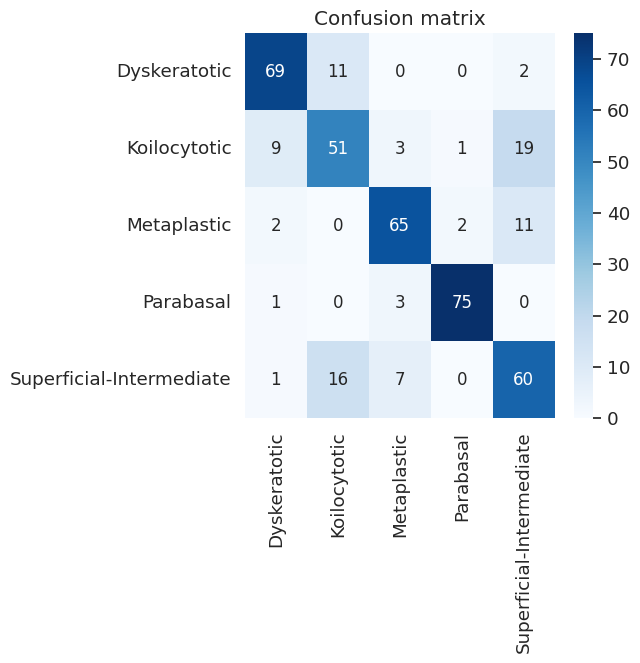

In [20]:
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn.metrics import confusion_matrix
# Convert lists to numpy arrays
all_predictions_ = np.array(all_predictions)
true_labels_ = np.array(true_labels)

# Display confusion matrix using seaborn heatmap
class_names = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
CM = confusion_matrix(true_labels, all_predictions)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 12}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()

In [21]:
global_net.eval()

FederatedNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have 'all_predictions' and 'true_labels' from the previous code snippet

# Calculate and print accuracy
prec_score = precision_score(true_labels, all_predictions, average='weighted') * 100
rec_score = recall_score(true_labels, all_predictions, average='weighted') * 100
f1score = f1_score(true_labels, all_predictions, average='weighted') * 100

print(f'precision score was {prec_score:6.2f}%\nrecall score was {rec_score:6.2f}%')
print(f'f1 score was {f1score:6.2f}%\n')
accuracy = accuracy_score(true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print precision, recall, and F1-score for each class
precision = precision_score(true_labels, all_predictions, average=None)
recall = recall_score(true_labels, all_predictions, average=None)
f1 = f1_score(true_labels, all_predictions, average=None)

for i in range(len(precision)):
    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}')

# Print the overall classification report
print('\nClassification Report:')
print(classification_report(true_labels, all_predictions))

precision score was  78.60%
recall score was  78.43%
f1 score was  78.47%

Accuracy: 0.7843
Class 0 - Precision: 0.8415, Recall: 0.8415, F1-score: 0.8415
Class 1 - Precision: 0.6538, Recall: 0.6145, F1-score: 0.6335
Class 2 - Precision: 0.8333, Recall: 0.8125, F1-score: 0.8228
Class 3 - Precision: 0.9615, Recall: 0.9494, F1-score: 0.9554
Class 4 - Precision: 0.6522, Recall: 0.7143, F1-score: 0.6818

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        82
           1       0.65      0.61      0.63        83
           2       0.83      0.81      0.82        80
           3       0.96      0.95      0.96        79
           4       0.65      0.71      0.68        84

    accuracy                           0.78       408
   macro avg       0.79      0.79      0.79       408
weighted avg       0.79      0.78      0.78       408



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

In [24]:
# Displays the ROC AUC for each class
from sklearn.metrics import roc_auc_score
# Convert lists to numpy arrays
all_predictions_ = np.array(all_predictions)
true_labels_ = np.array(true_labels)
def roc_auc_score_multiclass(actual_class, pred_class, average = "micro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

print("ROC AUC score for each class")
# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(true_labels, all_predictions)
print(lr_roc_auc_multiclass)

ROC AUC score for each class
{0: 0.9007930570103246, 1: 0.7656904541241891, 2: 0.8864329268292682, 3: 0.9701242737870801, 4: 0.8077601410934745}


In [25]:
preds = torch.zeros((0,5))
labels = torch.zeros((0))
global_net.eval()
with torch.no_grad():
    for i, (images, label) in enumerate(testloader):
        pred = global_net(images)
        preds = torch.cat((preds,pred),dim = 0)
        labels = torch.cat((labels,label.float()))

# one hot encoding test labels
y_true = np.zeros(preds.shape)
for i in range (preds.shape[0]):
    for j in range(preds.shape[1]):
        y_true[i][j] = 1 if labels[i]== j else 0

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = preds.shape[1]
out = preds.cpu().detach().numpy()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], out[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), out.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
out = preds.cpu().detach().numpy()
print(out)
roc_auc_score(y_true.ravel(), out.ravel(), labels = classes_dir, multi_class = 'ovr', average = 'micro')

[[  7.6769786   3.3316185   1.6681429  -4.51795    -3.8298094]
 [  5.2385716   4.969712   -2.112207    2.2061605  -7.5929546]
 [  7.5719485   3.0989265   2.1722155  -8.117479    0.6693479]
 ...
 [ -0.7648301   2.3526073  -0.1662275  -3.8851576   4.7357893]
 [  4.17427     8.571696   -6.315063  -10.554201    7.8824663]
 [  2.1902645   6.7151837  -2.0885959 -11.586224    9.232756 ]]


0.899717055940023

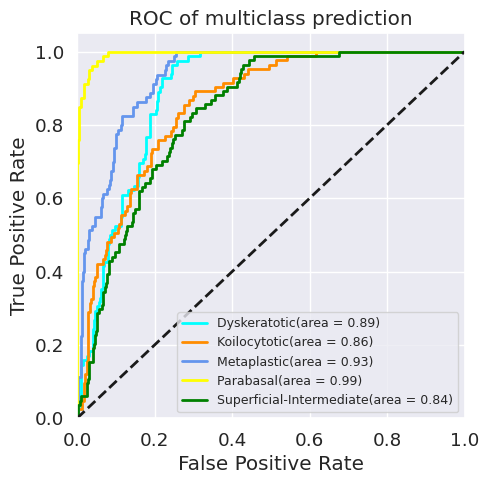

In [28]:
colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow","green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="{0}(area = {1:0.2f})".format(classes_dir[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of multiclass prediction")
# Adding legend with fontsize and lower right alignment
plt.legend(loc="lower right", fontsize='9')
plt.show()

In [29]:
_, y_pred = torch.max(preds, dim=1)

In [30]:
# Calculate and print test accuracy
accuracy = accuracy_score(labels.cpu(), y_pred.cpu())
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7868


In [31]:
from sklearn.metrics import classification_report
target_names = [classes_dir[i] for i in range(5)]
print(classification_report(labels.cpu(), y_pred.cpu(), target_names = target_names))
print('Note: In binary classification, recall of the positive class is also known as “sensitivity”; \n\
recall of the negative class is “specificity”.')

                          precision    recall  f1-score   support

            Dyskeratotic       0.93      0.82      0.87        82
            Koilocytotic       0.70      0.69      0.70        83
             Metaplastic       0.78      0.80      0.79        80
               Parabasal       0.95      0.91      0.93        79
Superficial-Intermediate       0.63      0.73      0.67        84

                accuracy                           0.79       408
               macro avg       0.80      0.79      0.79       408
            weighted avg       0.80      0.79      0.79       408

Note: In binary classification, recall of the positive class is also known as “sensitivity”; 
recall of the negative class is “specificity”.


In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from torch.utils.data import DataLoader
# import torch.nn.functional as F
# import torch

# model=global_net
# # Assuming you have 'all_predictions' and 'true_labels' from the previous code snippet
# # Assuming you have a PyTorch model named 'model' and a DataLoader named 'testloader'

# # Set the model to evaluation mode
# model.eval()

# # Initialize lists to store true labels and predicted probabilities
# true_labels = []
# predicted_probs = []

# # Iterate through the test set and collect true labels and predicted probabilities
# with torch.no_grad():
#     for test_data, test_labels in testloader:
#         outputs = model(test_data)
#         probs = F.softmax(outputs, dim=1)
#         true_labels.extend(test_labels.numpy())
#         predicted_probs.extend(probs.numpy())

# # Convert lists to numpy arrays
# true_labels = np.array(true_labels)
# predicted_probs = np.array(predicted_probs)

# # Binarize the true labels
# num_classes = 5
# true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multiclass Classification')
# plt.legend(loc='lower right')
# plt.show()